In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


# Dataset Reorganizing

Here we would like to first work on a subset of the dataset

In [4]:
# Read the metadata.csv file into a pandas DataFrame
# path = '/content/drive/My Drive/DukeStudies/548L_MLI_Project/Skin_Lesion_Classification/HAM2/'
path = '/content/drive/MyDrive/Sp23/BME548L_Machine_Learning_and_Imaging/548L_MLI_Project/Skin_Lesion_Classification/HAM2/'


In [5]:
df = pd.read_csv(path+'HAM10000_metadata.csv')
df.shape
df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [6]:
listdir = os.listdir

# Get the contents of the subset
contents = listdir(path+'HAM10000_images_part_1/')

# Filter the results to only include image files
image_files = [file for file in contents if file.endswith('.jpg')]

# Convert the results to a list
image_file_names = list(image_files)
len(image_file_names)

1661

In [7]:
image_file_names[1] # To check on the image file name construction

'ISIC_0024954.jpg'

The file name of images is encoded as **image_id.jpg**.

In [8]:
# Use list comprehension to remove the extension from each image name
image_ids = [name.split('.')[0] for name in image_file_names]
image_ids[1]
len(image_ids)
subset = df[df['image_id'].isin(image_ids)]
subset.to_csv(path+'new_metadata.csv')
df1 = pd.read_csv(path+'new_metadata.csv')
df1.shape

(1661, 8)

In [9]:
image_paths = []

for image_id in df1['image_id']:
    image_path = os.path.join(path+'HAM10000_images_part_1', image_id + '.jpg')
    image_paths.append(image_path)

In [10]:
# Load the VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [11]:
# # Load the metadata.csv file
# labels = df1['dx']

In [12]:
df1['image_path'] = image_paths
df1 = df1.drop('Unnamed: 0', axis=1)
df1.shape

(1661, 8)

In [13]:
df1.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
0,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
1,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
2,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
3,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
4,HAM_0001396,ISIC_0025276,bkl,histo,55.0,female,trunk,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
5,HAM_0001949,ISIC_0025767,bkl,histo,70.0,male,trunk,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
6,HAM_0001601,ISIC_0025915,bkl,histo,75.0,male,upper extremity,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
7,HAM_0003301,ISIC_0025033,bkl,histo,60.0,male,back,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
8,HAM_0004884,ISIC_0025937,bkl,histo,75.0,male,upper extremity,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
9,HAM_0006574,ISIC_0025567,bkl,histo,40.0,male,back,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...


In [14]:
image_ids = df1['image_id']
image_paths = df1['image_path']

(600, 450)


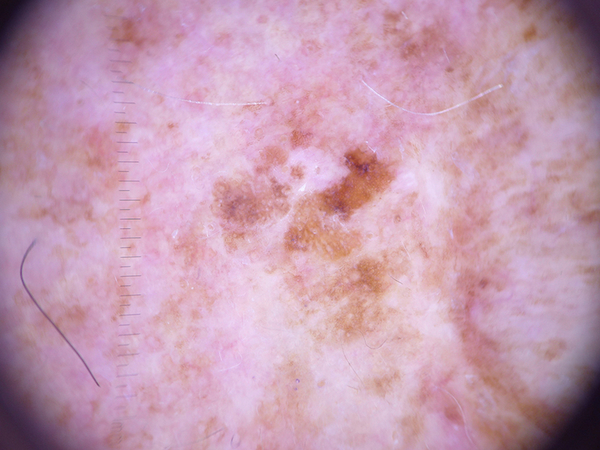

In [15]:
# loading a sample image
sample_image = Image.open(image_paths[0])
print(sample_image.size)
sample_image


#Model Training

In [16]:
metadata = pd.read_csv(path+'clean_metadata.csv')

(1661, 128, 128, 3)
(1661,)


(1328, 128, 128, 3)

(333, 128, 128, 3)

(1328, 7)

(333, 7)

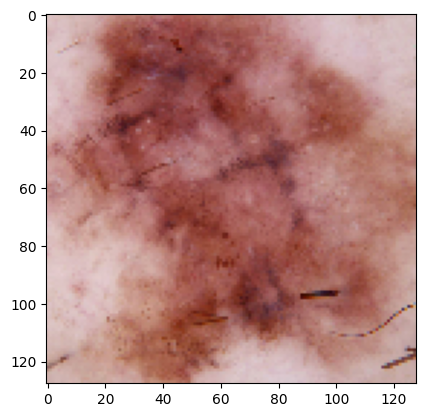

In [17]:
def load_and_crop(image, crop_size, normalized=True):
    width, height = image.size   # Get dimensions
    left = (width - crop_size)/2
    top = (height - crop_size)/2
    right = (width + crop_size)/2
    bottom = (height + crop_size)/2
    # Crop the center of the image
    # image = ImageOps.grayscale(image.crop((left, top, right, bottom)))
    image = image.crop((left, top, right, bottom))
    if normalized:
        return np.array(image).astype(np.float32) / 255.0
    else:
        return np.array(image).astype(np.float32)

# Load and preprocess the images
images = []
labels = []

for i, row in metadata.iterrows():
    image = load_img(row['image_path'], target_size=(150, 200))
    image = load_and_crop(image, 128)
    images.append(image)
    labels.append(row['dx'])

# Convert the images and labels to numpy arrays and adding a fake color channel
X = np.array(images).reshape(-1, 128, 128, 3)
print(X.shape)
y = np.array(labels)
print(y.shape)

# Convert the labels to integer values
y = pd.Series(labels).factorize()[0]

# Convert the labels to one-hot encoded vectors
y = to_categorical(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

plt.imshow(X_train[0])
# plt.colorbar()

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/5
67/67 [==============================] - 61s 115ms/step - loss: 6.4580 - accuracy: 0.5271 - val_loss: 6.6608 - val_accuracy: 0.6517
Epoch 2/5
67/67 [==============================] - 4s 59ms/step - loss: 5.6376 - accuracy: 0.6852 - val_loss: 6.0172 - val_accuracy: 0.6486
Epoch 3/5
67/67 [==============================] - 4s 62ms/step - loss: 5.2349 - accuracy: 0.7267 - val_loss: 5.4746 - val_accuracy: 0.6757
Epoch 4/5
67/67 [==============================] - 5s 67ms/step - loss: 4.7949 - accuracy: 0.7583 - val_loss: 4.9644 - val_accuracy: 0.7297
Epoch 5/5
67/67 [==============================] - 4s 58ms/step - loss: 4.4315 - accuracy: 0.7794 - val_loss: 4.5666 - val_accuracy: 0.7387


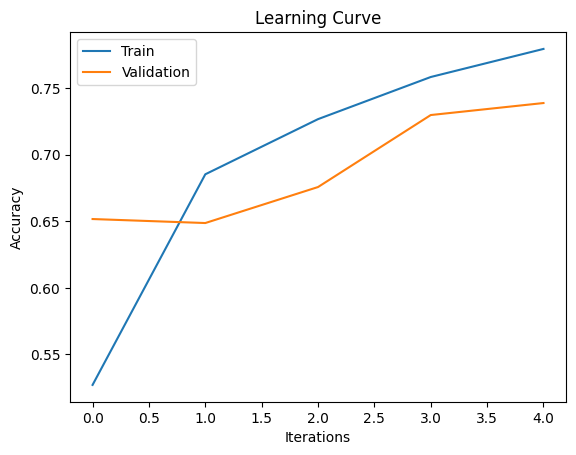

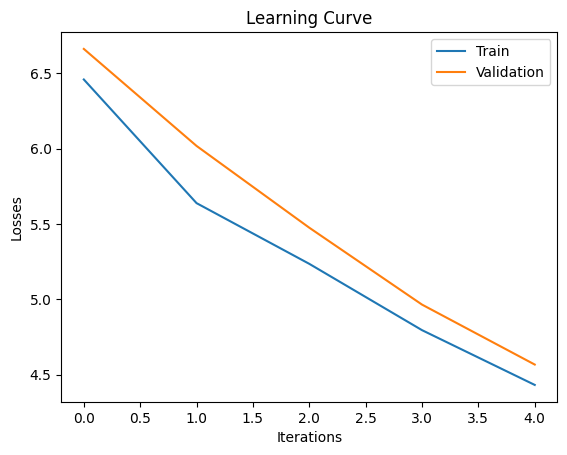

In [18]:
image_size = (128, 128, 3)

# Load the VGG16 model with imagenet weights
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg16.trainable = False

base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet',pooling='avg', input_shape=(128,128, 3))

model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Input(image_size),
    
    base_model,
    Dropout(0.5),
    Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)),
    Dropout(0.5),
    Dense(7, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02))
    
    # # convolutional layers:
    # tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides = 1, activation='relu'),
    # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides = 4, activation='relu'),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 1, activation='relu'),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 3, activation='relu'),

    # # dense layers:
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dense(7, activation='softmax')
])

# Compile the model with an Adam optimizer and cross-entropy loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training set
hist = model.fit(X_train, y_train, batch_size=20, epochs=5, validation_data=(X_test, y_test))

plt.title("Learning Curve")
plt.plot(np.arange(5),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(5),hist.history.get('val_accuracy'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Learning Curve")
plt.plot(np.arange(5),hist.history.get('loss'), label="Train")
plt.plot(np.arange(5),hist.history.get('val_loss'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.legend(loc='best')
plt.show()

In [58]:
# Create new weighted RGB image
import tensorflow.keras.backend as K

class WeightedRGBLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(WeightedRGBLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Define the trainable weights for the RGB channels
        self.r_weights = self.add_weight(name='r_weights', shape=(1,), initializer='uniform', trainable=True)
        self.g_weights = self.add_weight(name='g_weights', shape=(1,), initializer='uniform', trainable=True)
        self.b_weights = self.add_weight(name='b_weights', shape=(1,), initializer='uniform', trainable=True)

    def call(self, inputs):
        # Split the input image into its RGB channels
        r, g, b = tf.split(inputs, num_or_size_splits=3, axis=-1)

        # Scale the RGB channels by the trainable weights
        r_scaled = r * self.r_weights
        g_scaled = g * self.g_weights
        b_scaled = b * self.b_weights

        # Merge the scaled RGB channels into an image
        merged = tf.concat([r_scaled, g_scaled, b_scaled], axis=-1)

        return merged

    def compute_output_shape(self, input_shape):
        return input_shape

In [59]:
model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Input(image_size),
    
    # RGB regenerate layer
    WeightedRGBLayer(),
    
    base_model,
    Dropout(0.5),
    Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)),
    Dropout(0.5),
    Dense(7, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02))
    
    # # convolutional layers:
    # tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides = 1, activation='relu'),
    # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides = 4, activation='relu'),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 1, activation='relu'),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 3, activation='relu'),

    # # dense layers:
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dense(7, activation='softmax')
])

# Compile the model with an Adam optimizer and cross-entropy loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 weighted_rgb_layer_4 (Weigh  (None, 128, 128, 3)      3         
 tedRGBLayer)                                                    
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 128)               262272    
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 7)                 903       
                                                      

In [63]:
class PlotLayerOutputCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer_index, img, plot_freq=5):
        super(PlotLayerOutputCallback, self).__init__()
        self.layer_index = layer_index
        self.plot_freq = plot_freq
        self.img = img
        
    def on_epoch_end(self, epoch, logs=None):
        
        # if epoch == 0:
        if (epoch+1) % self.plot_freq == 0:
            layer_output_func = tf.keras.backend.function([self.model.layers[0].input],
                                                           [self.model.layers[self.layer_index].output])
            layer_output = layer_output_func(self.img)[0] * 255
            plt.imshow(layer_output[0])
            plt.show()

plot_callback = PlotLayerOutputCallback(layer_index = 0, plot_freq = 5, img = X_train[0:2])

Epoch 1/35
67/67 [==============================] - 136s 100ms/step - loss: 6.1317 - accuracy: 0.6130 - val_loss: 7.9520 - val_accuracy: 0.6517
Epoch 2/35
67/67 [==============================] - 4s 67ms/step - loss: 5.2398 - accuracy: 0.7959 - val_loss: 6.5069 - val_accuracy: 0.6577
Epoch 3/35
67/67 [==============================] - 4s 62ms/step - loss: 4.7056 - accuracy: 0.8652 - val_loss: 5.2998 - val_accuracy: 0.7177
Epoch 4/35
67/67 [==============================] - 5s 74ms/step - loss: 4.2864 - accuracy: 0.8931 - val_loss: 4.9973 - val_accuracy: 0.7207
Epoch 5/35
67/67 [==============================] - ETA: 0s - loss: 3.8705 - accuracy: 0.9224

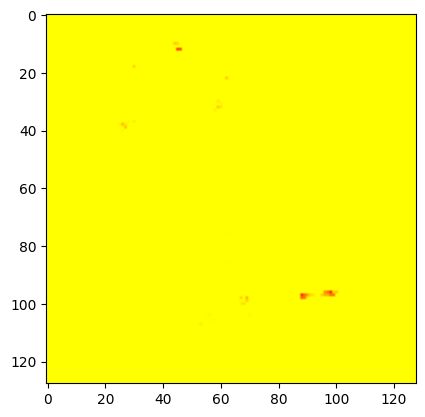

67/67 [==============================] - 5s 71ms/step - loss: 3.8705 - accuracy: 0.9224 - val_loss: 4.7551 - val_accuracy: 0.7297
Epoch 6/35
67/67 [==============================] - 4s 66ms/step - loss: 3.4872 - accuracy: 0.9488 - val_loss: 4.2302 - val_accuracy: 0.7207
Epoch 7/35
67/67 [==============================] - 5s 77ms/step - loss: 3.1607 - accuracy: 0.9616 - val_loss: 4.0517 - val_accuracy: 0.7417
Epoch 8/35
67/67 [==============================] - 4s 62ms/step - loss: 2.8873 - accuracy: 0.9586 - val_loss: 3.6390 - val_accuracy: 0.7718
Epoch 9/35
67/67 [==============================] - 4s 62ms/step - loss: 2.6248 - accuracy: 0.9631 - val_loss: 3.5076 - val_accuracy: 0.7327
Epoch 10/35
67/67 [==============================] - ETA: 0s - loss: 2.3713 - accuracy: 0.9714

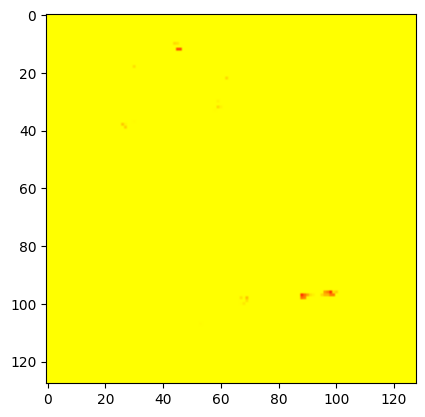

67/67 [==============================] - 5s 78ms/step - loss: 2.3713 - accuracy: 0.9714 - val_loss: 3.3604 - val_accuracy: 0.7477
Epoch 11/35
67/67 [==============================] - 4s 63ms/step - loss: 2.1204 - accuracy: 0.9782 - val_loss: 3.1172 - val_accuracy: 0.7658
Epoch 12/35
67/67 [==============================] - 4s 63ms/step - loss: 1.9259 - accuracy: 0.9774 - val_loss: 2.9912 - val_accuracy: 0.7477
Epoch 13/35
67/67 [==============================] - 5s 76ms/step - loss: 1.7455 - accuracy: 0.9819 - val_loss: 4.0485 - val_accuracy: 0.6907
Epoch 14/35
67/67 [==============================] - 4s 63ms/step - loss: 1.6398 - accuracy: 0.9721 - val_loss: 2.6830 - val_accuracy: 0.7327
Epoch 15/35
67/67 [==============================] - ETA: 0s - loss: 1.4535 - accuracy: 0.9804

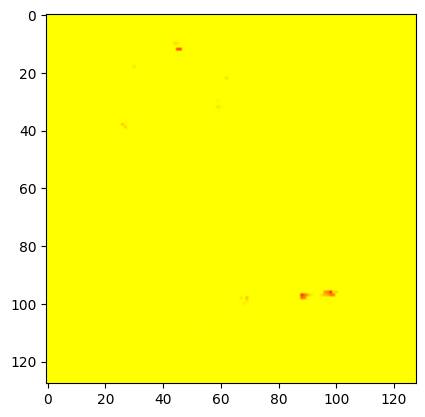

67/67 [==============================] - 5s 68ms/step - loss: 1.4535 - accuracy: 0.9804 - val_loss: 2.4099 - val_accuracy: 0.7357
Epoch 16/35
67/67 [==============================] - 5s 73ms/step - loss: 1.3028 - accuracy: 0.9880 - val_loss: 2.5276 - val_accuracy: 0.7568
Epoch 17/35
67/67 [==============================] - 4s 62ms/step - loss: 1.1666 - accuracy: 0.9940 - val_loss: 2.1600 - val_accuracy: 0.7538
Epoch 18/35
67/67 [==============================] - 5s 76ms/step - loss: 1.0842 - accuracy: 0.9849 - val_loss: 2.2584 - val_accuracy: 0.7207
Epoch 19/35
67/67 [==============================] - 5s 72ms/step - loss: 0.9860 - accuracy: 0.9880 - val_loss: 2.1683 - val_accuracy: 0.7447
Epoch 20/35
67/67 [==============================] - ETA: 0s - loss: 0.9276 - accuracy: 0.9827

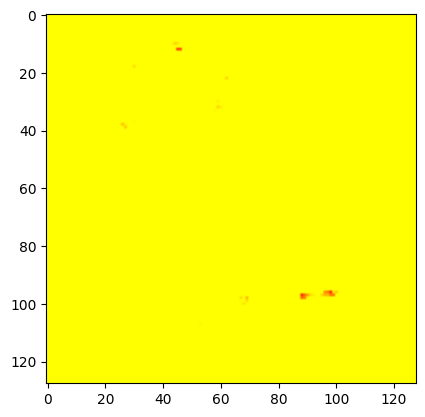

67/67 [==============================] - 4s 67ms/step - loss: 0.9276 - accuracy: 0.9827 - val_loss: 1.8408 - val_accuracy: 0.7237
Epoch 21/35
67/67 [==============================] - 5s 73ms/step - loss: 0.8298 - accuracy: 0.9864 - val_loss: 1.9869 - val_accuracy: 0.7327
Epoch 22/35
67/67 [==============================] - 4s 65ms/step - loss: 0.7508 - accuracy: 0.9895 - val_loss: 1.7980 - val_accuracy: 0.7508
Epoch 23/35
67/67 [==============================] - 4s 63ms/step - loss: 0.6908 - accuracy: 0.9864 - val_loss: 1.8823 - val_accuracy: 0.7598
Epoch 24/35
67/67 [==============================] - 5s 75ms/step - loss: 0.6335 - accuracy: 0.9902 - val_loss: 1.6011 - val_accuracy: 0.7477
Epoch 25/35
67/67 [==============================] - ETA: 0s - loss: 0.5862 - accuracy: 0.9880

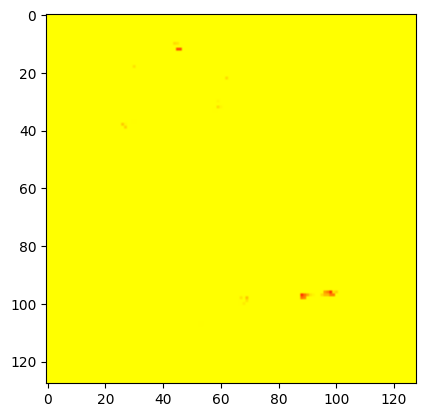

67/67 [==============================] - 4s 67ms/step - loss: 0.5862 - accuracy: 0.9880 - val_loss: 1.6319 - val_accuracy: 0.7177
Epoch 26/35
67/67 [==============================] - 4s 63ms/step - loss: 0.5429 - accuracy: 0.9880 - val_loss: 1.6871 - val_accuracy: 0.7417
Epoch 27/35
67/67 [==============================] - 5s 77ms/step - loss: 0.4818 - accuracy: 0.9940 - val_loss: 1.6942 - val_accuracy: 0.7598
Epoch 28/35
67/67 [==============================] - 4s 63ms/step - loss: 0.4598 - accuracy: 0.9895 - val_loss: 1.5155 - val_accuracy: 0.7297
Epoch 29/35
67/67 [==============================] - 4s 63ms/step - loss: 0.4334 - accuracy: 0.9887 - val_loss: 1.6010 - val_accuracy: 0.7357
Epoch 30/35
67/67 [==============================] - ETA: 0s - loss: 0.3912 - accuracy: 0.9887

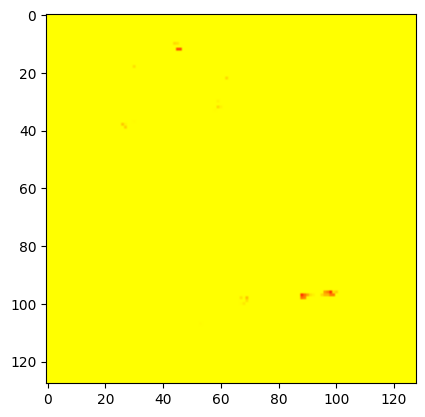

67/67 [==============================] - 5s 80ms/step - loss: 0.3912 - accuracy: 0.9887 - val_loss: 1.5679 - val_accuracy: 0.7688
Epoch 31/35
67/67 [==============================] - 4s 67ms/step - loss: 0.3700 - accuracy: 0.9917 - val_loss: 1.6376 - val_accuracy: 0.7237
Epoch 32/35
67/67 [==============================] - 5s 68ms/step - loss: 0.3520 - accuracy: 0.9910 - val_loss: 1.4707 - val_accuracy: 0.7748
Epoch 33/35
67/67 [==============================] - 5s 73ms/step - loss: 0.3180 - accuracy: 0.9932 - val_loss: 1.3324 - val_accuracy: 0.7508
Epoch 34/35
67/67 [==============================] - 4s 63ms/step - loss: 0.3034 - accuracy: 0.9940 - val_loss: 1.4756 - val_accuracy: 0.7387
Epoch 35/35
67/67 [==============================] - ETA: 0s - loss: 0.2770 - accuracy: 0.9955

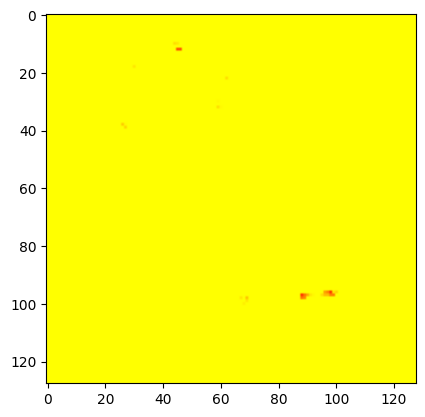

67/67 [==============================] - 5s 77ms/step - loss: 0.2770 - accuracy: 0.9955 - val_loss: 1.3234 - val_accuracy: 0.7508


In [64]:
# Train model with callback
hist = model.fit(X_train, y_train, batch_size=20, epochs=35, validation_data=(X_test, y_test), callbacks=[plot_callback])



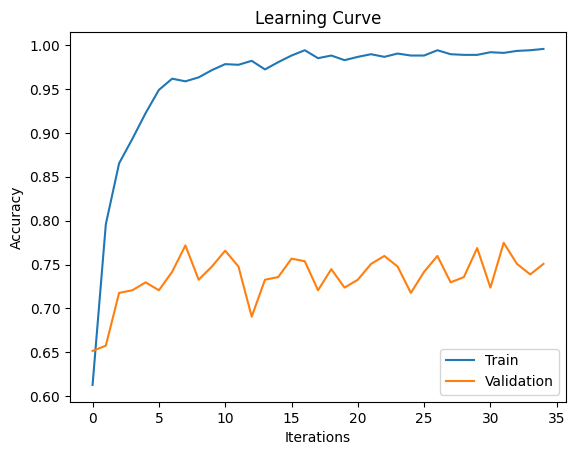

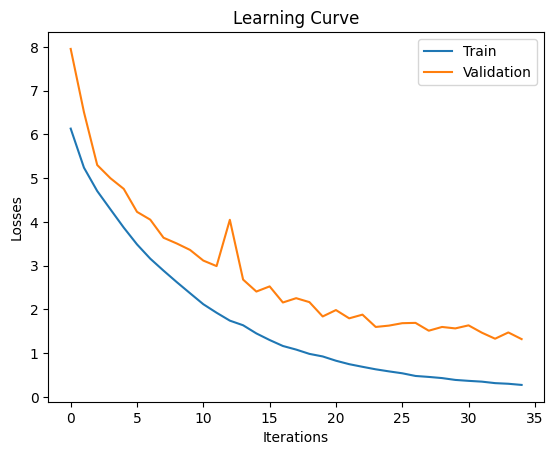

In [65]:
plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_accuracy'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('loss'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_loss'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.legend(loc='best')
plt.show()